<a href="https://colab.research.google.com/github/duberii/pid-playground/blob/main/activities/Ionization_Energy_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ionization Energy Loss**
---
Welcome to Particle Identification Playground! This activity is designed to introduce you to ionization energy loss, how it's calculated, and how it's used to identify particles.
**Before attempting this notebook, complete all of the activities in the Getting Started section. Also, be sure to complete the "Drift Chambers and Tracks" notebook before this one.**

**After completing this notebook, you will be able to:**
*   Name the effects that cause different particles to lose different amounts of energy in drift chambers
*   Demonstrate the separation power of dE/dx analysis using ROOT’s TH2D class
*   Classify different charged particles based on their energy loss at fixed momentum






In [1]:
#@title Run this cell before starting. This may take a few minutes to run.
!pip install -qqq pidp_tools
from pidp_tools import *
install_ROOT()
import pandas
from ROOT import gROOT, TCanvas, TH1D, TH2D
import pandas as pd
import numpy as np
import plotly.express as pxp
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive, fixed, widgets, HBox, VBox, Layout
from PIL import Image
import plotly as ply
import plotly.graph_objects as go
import math

!wget -q -O GlueX_Particle_Gun_Simplified.hdf5 https://github.com/duberii/pid-playground/raw/main/data/GlueX_Particle_Gun_Simplified.hdf5
!wget -q -O particle_data.hdf5 https://github.com/duberii/pid-playground/raw/main/data/particle_data.hdf5
!wget -q -O CDC_hits.hdf5 https://github.com/duberii/pid-playground/raw/main/data/CDC_hits.hdf5
!wget -q -O SC.hdf5 https://github.com/duberii/pid-playground/raw/main/data/SC.hdf5
!wget -q -O TOF.hdf5 https://github.com/duberii/pid-playground/raw/main/data/TOF.hdf5
!wget -q -O FDC.hdf5 https://github.com/duberii/pid-playground/raw/main/data/FDC.hdf5

from google.colab import output
output.enable_custom_widget_manager()
particle_data = pd.read_hdf("GlueX_Particle_Gun_Simplified.hdf5")
CDC_hits = pd.read_hdf("CDC_hits.hdf5")
SC = pd.read_hdf("SC.hdf5")
TOF = pd.read_hdf("TOF.hdf5")
FDC = pd.read_hdf("FDC.hdf5")
CDC_hits['t'] = CDC_hits['t'].apply(np.array)
CDC_hits['q'] = CDC_hits['q'].apply(np.array)
CDC_hits['p'] = (CDC_hits['px']**2 + CDC_hits['py']**2 + CDC_hits['pz']**2)**0.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00
Welcome to JupyROOT 6.30/04


---
##**Ionization Energy Loss**
---
As mentioned in the previous notebook, drift chambers use the fact that charged particles can strip electrons from atoms as they pass through a gas. This process, known as **Ionization**, transfers some of the energy (and momentum) from the particle to the electrons. Compared to the total energy and momentum of the particle, this loss is small, so it doesn't affect any other measurements that we may want to make. However, we can still measure this energy loss and use it to classify particles.

It turns out that different particles will lose energy at different rates in the detector. However, particles also lose different amounts of energy based on the distance they travel in the detector. The greater the distance the particle travels in the detector, the more energy it will lose. To correct for this, we can consider the total energy lost ($dE$) divided by the distance traveled in the detector ($dx$), which yields a quantity called **energy loss per unit length** ($dE/dx$). This quantity should help us distinguish between different particles, which we will explore in later sections.

---
##**Calculating Ionization Energy Loss [Optional]**
---

In this section, we will see how we can calculate the ionization energy loss from individual hits in the CDC. However, the process displayed in this part is done automatically by the detector, so it can be skipped without losing any understanding of the particle identification method that uses ionization energy loss.

---
###**Step 1: Calculating Energy Loss**
---

To figure out the energy loss per unit length, we first need to find the total energy loss, $dE$. The way $dE$ is calculated is too complex to be worth discussing here (especially since we never calculate it manually), but it is calculated from the timing of the pulses of electricity that we detect and the total charge we detect.


We can get an estimate of the total energy lost by assuming that the energy lost is proportional to the charge we detect. Why might we assume this? Recall that a charged particle creates other charged particles in the drift chamber via ionization, which is the process of removing electrons from atoms. If you have taken a chemistry class, you may recall that electrons sit in energy levels. In other words, all electrons in the same energy level take the same amount of energy to remove them from the atom.

####**Question #1:**
---
Let's say that it takes an energy of $E_{ionization}$ to remove a single electron from an atom. If we detect a total charge of $Q$ as a particle passes through a straw, how much energy did the particle lose? In other words, what is $dE$? **Hint:** How can we convert the charge we detected into a number of electrons we detected?

Double click to edit this cell and answer the following question: How much energy did the particle lose?

#####**Solution:**

It must be true that
$$dE = N * E_{ionization}$$
where $N$ is the number of electrons we detect. This equation simply says that the total energy lost is equal to the energy lost per electron times the number of electrons.

All we have left to do is find the relationship between the charge we detect ($Q$) and the total number of electrons we detected ($N$). To do this, we just notice that if we multiply the total number of electrons detected ($N$) by the charge per electron ($e$), we should get the total charge we detected. In other words,
$Q = e*N$
If we divide by $e$ on both sides, we get:
$$N=\frac{Q}{e}$$
Plugging this into our expression for $dE$, we get:
$$
dE = \frac{Q}{e}*E_{ionization}
$$
where $dE$ is the energy lost in the straw, $Q$ is the total charge we detected, $e$ is the charge of an electron, and $E_{ionization}$ is the energy it takes to remove a single electron from an atom of the gas in the drift chamber.

####**Question #2:**
---
The equation from the previous question is only an estimate of the energy lost because it only takes into account the ionization energy of the gas. What other kind of energy might an electron have after it is removed from an atom?

Double click to edit this cell and answer the following question: What other kind of energy might an electron have after it is removed from an atom?

#####**Solution:**

For an electron to be removed from an atom, it has to move! Kinetic energy is the energy associated with motion. Without further information, it is extremely difficult to find out what the kinetic energy of the ionized electrons would be. It depends on what kind of particle is ionizing the atoms and how fast that particle is moving, which we have no way of finding out (in fact, the whole point of us doing this is to figure out the type of particle that is ionizing the atoms- that's the point of PID!).

There are tons of other things that could affect the energy loss, but the main three worth mentioning are:

1.   A charged particle ionizing multiple electrons from the same atom, which would change the ionization energy
2.   A charged particle ionizing an electron from a lower energy level, which would change the ionization energy
3.   An ionized electron moves so fast that it ionizes another electron, which would affect our ability to accurately calculate the number of atoms ionized by a charged particle.

In practice, the detector gets around all this by "guessing" the type of particle that ionized the atoms. This allows it to calculate the energy loss more accurately for each of its guesses, but it doesn't help us figure out which "guess" is correct, which is why we still need PID.

####**Question #3:**
---
The GlueX Central Drift Chamber uses mainly argon gas. For argon, the average ionization energy is:
$$E_{ionization}\approx 30 \mbox{ eV} $$
 Using this information, along with the equation from Question #1, add a `dE` column to the `CDC_hits` dataframe. You can calculate `dE` using the `N` column of the dataframe, which has the number of electrons detected.

In [ ]:
CDC_hits['dE']=

#####**Solution:**

We will use the equation: $$
dE = N * E_{ionization}
$$ where $N$ is the number of electrons detected and $E_{ionization}$ is the ionization energy. See more about this equation in the solution to Question #1.

In [2]:
CDC_hits['dE'] = 30 * CDC_hits['q']

---
###**Step 2: Calculating Path Length**
---

The other part of ionization energy loss is $dx$, often called the **path length** of the track. The path length refers to the distance that the particle traveled through the detector. However, we only need to measure the distance that the particle travels inside the straws of the drift chamber. Recall that the Central Drift Chamber (CDC) of the GlueX experiment is actually a straw chamber, meaning it is a bundle of "straws." Each straw is a positive wire surrounded by a negatively charged tube.

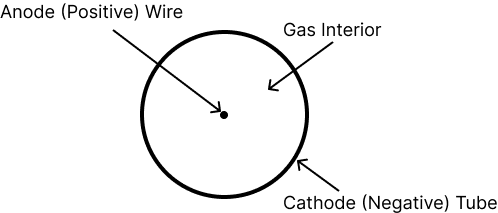

Over a thousand straws are stacked to form the CDC, but because of the shape of the straws, there are small gaps between them. In these regions, the particles still lose energy, but we can't measure the energy lost. In reality, this isn't an issue because the energy lost while traveling through the drift chamber is so small compared to the total energy of the particle. However, to ensure that we have an accurate rate of energy loss, we only want to consider the distance that the particle travels inside the straw.

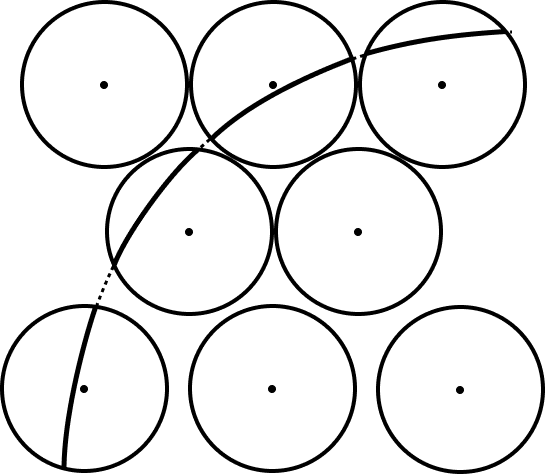

For example, in the picture above, the dotted portions of the track are outside of all of the straws, so we aren't able to measure the energy lost in those regions.

How do we measure the distance the particle traveled inside the straw? Again, this part is a little too complicated to be worth deriving manually. However, we can calculate the distance that the particle travels inside the straw based on the timing of the signal we detect. This is because the majority of the delay in our signal actually comes from the time it takes for the ionized particles to reach the charged wire (the "drift time").

Run the cell below to add a `dx` column to the `CDC_hits` dataframe, which is calculated based on the timing of the hits. You don't need to modify anything in this cell- just be sure to run it!

In [3]:
CDC_hits['dx']= CDC_hits['t'].apply(lambda t: 1.7*(np.log(0.00033*t+1))**0.5)

<ipython-input-3-cfb514eb471e>:1: RuntimeWarning: invalid value encountered in sqrt
  CDC_hits['dx']= CDC_hits['t'].apply(lambda t: 1.7*(np.log(0.00033*t+1))**0.5)


---
###**Step 3: Calculating Ionization Energy Loss**
---

We are finally ready to calculate the ionization energy loss! Based on the timing information and the total charge we detect, we can calculate the energy loss ($dE$) and the path length ($dx$) for each hit. However, because the distance traveled in each straw is so small, it's difficult to get an accurate measure of ionization energy loss for an individual straw. However, if we consider the total energy loss of the track and the total path length of the track (but again, only the length of the path inside the straws), we can get a much more accurate value. These are the steps we will take to calculate the ionization energy loss:

1.  For every hit, calculate the energy loss ($dE$) and the path length ($dx$).
2.  Find the total energy losses and path length for the track.
3.  Calculate the ionization energy loss ($dE/dx$).

In steps 1 and 2, you completed the first item, so we only need to worry about item 2 and item 3.

####**Question #4:**
---
Each row in the `CDC_hits` dataframe represents a single track. In the `dE` and `dx` columns you calculated, there is a list that contains the $dE$ and $dx$ values for each hit associated with that track.

**Note:** The `sum` method of the dataframe will find the sum of the entire column (instead of taking the sum track-by-track). Instead, to calculate the total energy loss and total path length, you should use the `.apply(sum)`. For example, to calculate the total energy lost by each track, you would do something like:
```
CDC_hits['total dE']= CDC_hits['dE'].apply(sum)
```

In the cell below, write code that calculates the sum of the $dE$ values and the sum of the $dx$ values, calculates the ionization energy loss value, then stores the result in another column called `dE/dx`.

In [ ]:
CDC_hits['dE/dx']=

#####**Solution:**

In [4]:
CDC_hits['dE/dx']=CDC_hits['dE'].apply(sum)/CDC_hits['dx'].apply(sum)

---
##**Plotting Ionization Energy Loss**
---
The best way to see how ionization energy loss helps us identify particles is to visualize the relationship between ionization energy loss and momentum. These next few questions will walk you through creating an ionization energy loss plot. It may be useful to review the "Introduction to ROOT" and "2D Histograms in ROOT" activities before completing this section.

####**Question #5:**
---

In the cell below, create a canvas with the following properties using ROOT's TCanvas constructor:



*   Name: "c1"
*   Title: "Ionization Energy Loss Plot"
*   Width: 700
*   Height: 500

In [ ]:
canvas =

#####**Solution:**

In [5]:
canvas = TCanvas("c1","Ionization Energy Loss Plot",700,500)

####**Question #6:**
---
In the cell below, create a 2D Histogram with the following properties using ROOT's TH2D constructor:

Write code in the cell below to create a histogram with the following properties:

*   Name: "h1"
*   Title: "Ionization Energy Loss vs. Momentum"
*   X axis label: "Momentum (GeV/c)"
*   Y axis label: "Ionization Energy Loss"
*   Number of bins: 200 (both X and Y)
*   Minimum X value: 0
*   Maximum X value: 1
*   Minimum Y value: 0
*   Maximum Y value: 0.00002 $\left (2 * 10^{-5}\right )$

In [ ]:
h1 =

#####**Solution:**

In [6]:
h1 = TH2D("h1","Ionization Energy Loss vs. Momentum;Momentum (GeV/c);Ionization Energy Loss",200,0,1,200,0,2*10**-5)

####**Question #7**
---
Complete the loop in the cell below to use the Fill method of the TH2D object to fill in the histogram with the momenta and ionization energy losses stored in the dataframe called `particle_data`, which has a column named "p" (magnitude of momentum) and a column named "dEdxCDC" (ionization energy loss in the Central Drift Chamber). Finally, draw the filled histogram.

In [ ]:
for row in #Complete this code
  #Complete this code
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

#####**Solution:**

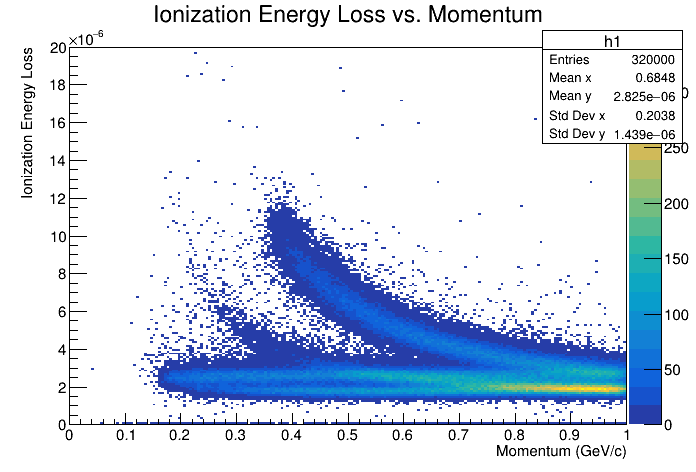

In [7]:
for row in particle_data.iloc:
  h1.Fill(row['p'],row['dEdxCDC'])
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

####**Question #8:**
---

You can also save canvases! In Google Colab, you can just right click and select "Save Image as". However, in many other situations, it is useful to save an image in your code. Lucky for us, ROOT's TCanvas class has a `SaveAs` method, which allows us to save an image. The syntax is as follows:
```
canvas.SaveAs("filename.png")
```

In the cell below, use the TH2D's `SetStats` method to remove the statistics box from the plot. Then, use TCanvas's `SaveAs` method to save your plot as "dEdxPlot.png".

#####**Solution:**

In [8]:
h1.SetStats(0)
canvas.SaveAs("dEdxPlot.png")

Info in <TCanvas::Print>: png file dEdxPlot.png has been created


**Note:** To check that your solution worked, you can click the folder icon shown to the left, which should show you all of the files that are saved on the remote computer that this notebook is running on. You should see a file in the menu called "dEdxPlot.png". If you'd like, you can right click the file and select "Download" to download the image to your computer. Otherwise, the file will be deleted when you close out of the notebook (files are not saved in Google Colab, but the code is saved, so you can come back and recreate the image at any time!)

#### **Question #9:**
---
If you completed the "Calculating Ionization Energy Loss" section, the `CDC_hits` dataframe should also have columns titled `p` and `dE/dx`. Create a 2D histogram of momentum vs. rate of ionization energy loss. Note that because the ionization energy loss is in a different unit than those in previous questions, the y range of your plot should be much larger. Try using these properties:

*   Name: "h1"
*   Title: "Ionization Energy Loss vs. Momentum"
*   X axis label: "Momentum (GeV/c)"
*   Y axis label: "Ionization Energy Loss"
*   Number of bins: 200 (both X and Y)
*   Minimum X value: 0
*   Maximum X value: 1
*   Minimum Y value: 0
*   Maximum Y value: 10000000


What do you notice about this plot?

In [ ]:
c1 =

Double click to edit this cell and answer the following question: What do you notice about this plot?

#####**Solution:**

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


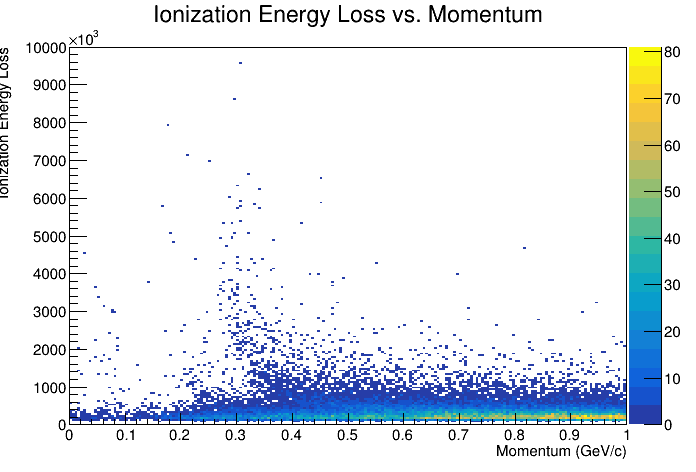

In [9]:
c1 = TCanvas("c1","c1",700,500)
h1 = TH2D("h1","Ionization Energy Loss vs. Momentum;Momentum (GeV/c);Ionization Energy Loss",200,0,1,200,0,10000000)
for row in CDC_hits.iloc:
  h1.Fill(row['p'],row['dE/dx'])
h1.SetStats(0)
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

Because we only estimated the energy loss, the plot doesn't look as nice as the other ones. However, we can still see one faint stripe (a vertical line around 0.3 GeV/c in momentum), which likely corresponds to a specific particle. However, the vast majority of the points are closer to 1 GeV/c in momentum and have very low energy loss, which is seen in the more accurate plots as well.

---
## **Interpreting Ionization Energy Loss Plots**
---
In the previous questions, you created a plot that looked something like this one:

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


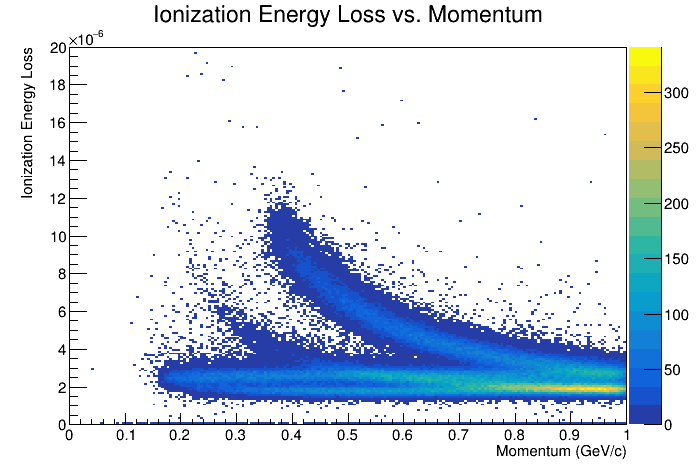

In [10]:
# @title
canvas = TCanvas("c1","Ionization Energy Loss Plot",700,500)
h1 = TH2D("h1","Ionization Energy Loss vs. Momentum;Momentum (GeV/c);Ionization Energy Loss",200,0,1,200,0,2*10**-5)
for row in particle_data.iloc:
  h1.Fill(row['p'],row['dEdxCDC'])
h1.SetStats(0)
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

You may notice that there are a few different stripes on the histogram where the bins are extra full. Each of these stripes corresponds to a different particle we detect! For low momentum (below 0.7 GeV/c), you'll notice that the different stripes are pretty far apart, which makes it pretty easy to tell them apart. However, at higher momentum (above 0.7 GeV/c), all of the stripes start to blend together, which makes high-momentum particles extremely difficult to identify. At lower momentum, ionization energy loss is an extremely powerful method of particle identification.

###**Question #10:**
---
The code below plots the ionization energy loss and momentum for particles identified as protons. Use the dropdown menu to change the particle that is plotted. Try to identify all of the stripes in the histogram shown above.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


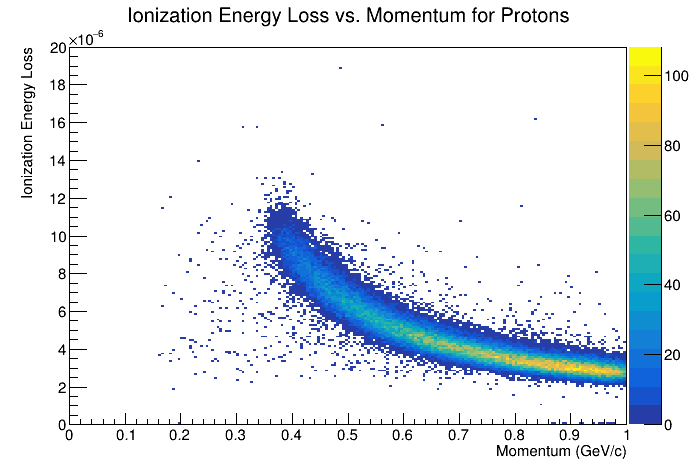

In [11]:
# @title { run: "auto" }
particle_to_plot = "Proton" # @param ["Proton", "Kaon+", "Pion+", "Electron"]
canvas = TCanvas("c1","Ionization Energy Loss Plot",700,500)
h1 = TH2D("h1","Ionization Energy Loss vs. Momentum for " + particle_to_plot + "s;Momentum (GeV/c);Ionization Energy Loss",200,0,1,200,0,2*10**-5)
for row in particle_data.loc[particle_data['Particle']== particle_to_plot].iloc:
  h1.Fill(row['p'],row['dEdxCDC'])
h1.SetStats(0)
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

####**Solution:**

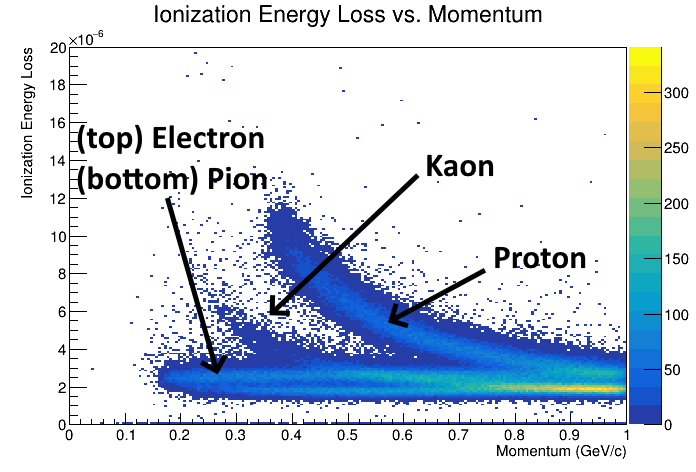

From top to bottom, we have Protons, Kaons, Electrons, then Pions.

---
##**Making Cuts**
---

To turn these stripes into a classification tool, we use **cuts**. Cuts are conditions that we use to make restrictions on our data. In many cases, our cuts take the form of inequalities. For example, we may say that if the mass of a particle is greater than 0.7 GeV/c^2, then it is a Proton. The corresponding cut would be $m>0.7$, where $m$ is the mass of the particle.


For ionization energy loss, our cuts are a little more complicated. The stripes resemble exponential decays, so we use cuts of the form:
$$
dE/dx * 10^6 > e^{a*p + b}+c
$$
or $$
dE/dx * 10^6 < e^{a*p + b}+c
$$
where $dE/dx$ is the ionization energy loss, $e$ is Euler's constant, $p$ is the magnitude of momentum, and $a, b,$ and $c$ are constants that we can change to find a good cut. Multiplying the ionization energy loss by $10^6$ makes it so that the constants $a$, $b$, and $c$ don't have to be ridiculous small.

Below, you can change the sliders for $a$, $b$, and $c$ to see their effect on the graph.

In [12]:
# @title
fig = interactive_image()
fig.update()
fig.display(a=(-10,0,0.01),b=(0,10,0.01), c=(0,10,0.01))

This equation is rescaled by 10**-6


Notice that $a$ changes how curved the line is, $b$ stretches it vertically, and $c$ just moves the line up and down. These three constants are enough to get extremely powerful cuts.

For example, the interactive plot shown below plots the graph of our cut over the ionization energy loss plot for protons.

In [13]:
# @title
particle_to_plot="Proton"
canvas = TCanvas("c1","Ionization Energy Loss Plot",700,500)
h1 = TH2D("h1","Ionization Energy Loss vs. Momentum for " + particle_to_plot + "s;Momentum (GeV/c);Ionization Energy Loss",200,0,1,200,0,2*10**-5)
for row in particle_data.loc[particle_data['Particle']== particle_to_plot].iloc:
  h1.Fill(row['p'],row['dEdxCDC'])
h1.SetStats(0)
h1.Draw('COLZ')
canvas.SaveAs("Proton.png")
fig = interactive_image("Proton.png")
fig.update()
fig.display(a=(-10,0,0.01),b=(0,10,0.01), c=(0,10,0.01))

This equation is rescaled by 10**-6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Info in <TCanvas::Print>: png file Proton.png has been created


If we set $a=-4.8$, $b=3.6$, and $c=1.5$, we get a line that separates the proton curve (displayed above) from all of the other curves. Therefore, when classifying our particles, we could say that a particle is a proton if:
$$
dE/dx * 10^6> e^{(-2.5*p+2.3)}+1.4
$$
We can also find a cut to place as an upper bound. In this case, we might require that:
$$
dE/dx * 10^6< e^{(-5.8*p+4.55)} + 3.45
$$
For protons, this is actually unnecessary, since there are no particles seen in the GlueX experiment that appear above protons in an ionization energy loss plot.

###**Question #11:**
---
Repeat the process described above to find cuts (both above and below) that help classify kaons, pions, and electrons.

**Note:** To make a horizontal line, you can set $a$ and $b$ to 0. Then, you can change $c$ to get a cut of the form $dE/dx * 10^6> c + 1$ or $dE/dx * 10^6 < c+1$. The $c+1$ comes from plugging $a=b=0$ into the exponential equation:
$$
e^{(0*p+0)}+c = e^0 + c = c + 1
$$

Double click to edit this cell and answer the following question: What cuts should be made for protons, kaons, pions, and electrons in the central drift chamber?

In [14]:
# @title { run: "auto" }
particle_to_plot = "Proton" # @param ["Proton", "Kaon+", "Pion+", "Electron"]
canvas = TCanvas("c1","Ionization Energy Loss Plot",700,500)
h1 = TH2D("h1","Ionization Energy Loss vs. Momentum for " + particle_to_plot + "s;Momentum (GeV/c);Ionization Energy Loss",200,0,1,200,0,2*10**-5)
for row in particle_data.loc[particle_data['Particle']== particle_to_plot].iloc:
  h1.Fill(row['p'],row['dEdxCDC'])
h1.SetStats(0)
h1.Draw('COLZ')
canvas.SaveAs(particle_to_plot + ".png")
fig = interactive_image(particle_to_plot + ".png")
fig.update()
fig.display(a=(-10,0,0.01),b=(0,10,0.01), c=(0,10,0.01))

This equation is rescaled by 10**-6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Info in <TCanvas::Print>: png file Proton.png has been created


####**Solution:**

**Proton:**

---
$$
dE/dx * 10^6> e^{(-2.5*p+2.3)}+1.4
$$
**Kaon:**

---
$$
dE/dx * 10^6 > e^{(-4.9*p+2.3)}+1.45
$$
and
$$
dE/dx * 10^6 < e^{(-4.36*p+2.3)}+2.3
$$
**Pion:**

---
$$
dE/dx * 10^6 > 2.25
$$
and $$
dE/dx * 10^6 < 3.14
$$
**Electron:**

---
$$
dE/dx * 10^6 > 1.59
$$
and
$$
dE/dx * 10^6 < 2.49
$$

###**Question #12:**
---
Finally, we will define a function to classify particles! Complete the function definition shown below to apply the cuts and identify particles based on their momentum and ionization energy loss! **Hint:** use `np.exp(a)` to calculate $e^a$.

In [ ]:
def identify_particle(p, dEdx):
  if #Condition for proton
    return "Proton"
  elif #Condition for kaon
    return "Kaon"
  elif #Condition for pion
    return "Pion"
  elif #Condition for electron
    return "Electron"
  else:
    return "No ID"

#####**Solution:**

In [15]:
def identify_particle(p, dEdx):
  if dEdx *10**6> np.exp(-2.5*p+2.3)+1.4:
    return "Proton"
  elif dEdx *10**6> np.exp(-4.9*p+2.3)+1.45 and dEdx *10**6< np.exp(-4.36*p+2.3)+2.3:
    return "Kaon+"
  elif dEdx *10**6> 1.59 and dEdx *10**6 < 2.49:
    return "Pion"
  elif dEdx *10**6> 2.25 and dEdx *10**6< 3.14:
    return "Electron"
  else:
    return "No ID"

###**Question #13:**
---
The forward drift chamber (FDC) measures the momentum of particles traveling in the positive z direction. Use the sliders below to find similar cuts for ionization energy loss in the forward drift chamber (FDC).

**Note:** The equation you find in this question is rescaled by $10^{-6}$. In other words, your cuts should use $dE/dx * 10^6$.

Double click to edit this cell and answer the following question: What cuts should be made for protons, kaons, pions, and electrons in the forward drift chamber (FDC)?

In [16]:
# @title
particle_to_plot = "Electron" # @param ["Proton", "K+", "Pi+", "Electron"]
canvas = TCanvas("c1","Ionization Energy Loss Plot",700,500)
h1 = TH2D("h1","Ionization Energy Loss vs. Momentum for " + particle_to_plot + "s in the FDC;Momentum (GeV/c);Ionization Energy Loss",200,0,5,200,0,0.00001)
FDC['p'] = (FDC['px']**2 + FDC['py']**2 + FDC['pz']**2)**0.5
for row in FDC.loc[(FDC['Generated As']== particle_to_plot)].iloc:
  h1.Fill(row['p'],row['FDC dEdx'])
h1.SetStats(0)
h1.Draw('COLZ')
canvas.SaveAs(particle_to_plot + "_FDC.png")
fig = interactive_image(particle_to_plot + "_FDC.png", x_max = 5, y_max = 0.00001)
fig.update()
fig.display(a=(-10,0,0.01),b=(0,10,0.01), c=(0,10,0.01))

This equation is rescaled by 10**-6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Info in <TCanvas::Print>: png file Electron_FDC.png has been created


#####**Solution:**

**Proton:**

---
$$
dE/dx * 10^6> e^{(-3.55*p+3.7)}+1.3
$$
**Kaon:**

---
$$
dE/dx * 10^3> e^{(-4.4*p+2)}+1.3
$$
and
$$
dE/dx * 10^3< e^{(-4.4*p+2)}+2.3
$$
**Pion:**

---
$$
dE/dx * 10^3> 1.45
$$
and $$
dE/dx * 10^3< 2.6
$$
**Electron:**

---
$$
dE/dx * 10^3> 2
$$
and
$$
dE/dx * 10^3< 3
$$

###**Question #14:**
---
We can also measure ionization energy loss in other detectors (not just drift chambers). One such detector is the start counter, which is the first detector that most particles come in contact with. It surrounds the target of the detector, so any charged particle that is created in the target should interact with the start counter. Use the sliders below to find similar cuts for ionization energy loss in the start counter.

**Note:** The equation you find in this question is rescaled by $10^{-3}$. In other words, your cuts should use $dE/dx * 10^3$.

Double click to edit this cell and answer the following question: What cuts should be made for protons, kaons, pions, and electrons in the start counter?

In [17]:
# @title
particle_to_plot = "Electron" # @param ["Proton", "K+", "Pi+", "Electron"]
canvas = TCanvas("c1","Ionization Energy Loss Plot",700,500)
h1 = TH2D("h1","Ionization Energy Loss vs. Momentum for " + particle_to_plot + "s in the Start Counter;Momentum (GeV/c);Ionization Energy Loss",200,0,2,200,0,0.01)
SC['p'] = (SC['px']**2 + SC['py']**2 + SC['pz']**2)**0.5
for row in SC.loc[(SC['Generated As']== particle_to_plot) & (SC['p'] <= 2)].iloc:
  h1.Fill(row['p'],row['SC dEdx'])
h1.SetStats(0)
h1.Draw('COLZ')
canvas.SaveAs(particle_to_plot + "_SC.png")
fig = interactive_image(particle_to_plot + "_SC.png", x_max = 2, y_max = 0.01)
fig.update()
fig.display(a=(-10,0,0.01),b=(0,10,0.01), c=(0,10,0.01))

This equation is rescaled by 10**-3


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Info in <TCanvas::Print>: png file Electron_SC.png has been created


#####**Solution:**

**Proton:**

---
$$
dE/dx * 10^3> e^{(-4*p+3.2)}+1.6
$$
**Kaon:**

---
$$
dE/dx * 10^3> e^{(-4.4*p+2.7)}+1.2
$$
and
$$
dE/dx * 10^3< e^{(-4.6*p+3.1)}+2.2
$$
**Pion:**

---
$$
dE/dx * 10^3> 1.3
$$
and $$
dE/dx * 10^3< 2.3
$$
**Electron:**

---
$$
dE/dx * 10^3> 2.3
$$
and
$$
dE/dx * 10^3< 1.3
$$

###**Question #15:**
---
We can also measure ionization energy loss in a detector called the time of flight detector (more on the time of flight detector in later notebooks). Use the sliders below to find similar cuts for ionization energy loss in the time of flight detector.

**Note:** The equation you find in this question is rescaled by $10^{-4}$. In other words, your cuts should use $dE/dx * 10^4$.

Double click to edit this cell and answer the following question: What cuts should be made for protons, kaons, pions, and electrons in the time of flight detector?

In [18]:
# @title
particle_to_plot = "Electron" # @param ["Proton", "K+", "Pi+", "Electron"]
canvas = TCanvas("c1","Ionization Energy Loss Plot",700,500)
h1 = TH2D("h1","Ionization Energy Loss vs. Momentum for " + particle_to_plot + "s in the Time of Flight Detector;Momentum (GeV/c);Ionization Energy Loss",200,0,5,200,0,0.002)
TOF['p'] = (TOF['px']**2 + TOF['py']**2 + TOF['pz']**2)**0.5
for row in TOF.loc[TOF['Generated As']== particle_to_plot].iloc:
  h1.Fill(row['p'],row['TOF dEdx'])
h1.SetStats(0)
h1.Draw('COLZ')
canvas.SaveAs(particle_to_plot + "_TOF.png")
fig = interactive_image(particle_to_plot + "_TOF.png", x_max = 5, y_max = 0.002)
fig.update()
fig.display(a=(-10,0,0.01),b=(0,10,0.01), c=(0,10,0.01))

This equation is rescaled by 10**-4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Info in <TCanvas::Print>: png file Electron_TOF.png has been created


#####**Solution:**

**Proton:**

---
$$
dE/dx * 10^4> e^{(-2.2*p+3.9)}+8.2
$$
**Kaon:**

---
$$
dE/dx * 10^4> e^{(-0.4*p+0.8)}+7.6
$$
and
$$
dE/dx * 10^4< e^{(-0.4*p+1.4)}+10
$$
**Pion:**

---
$$
dE/dx * 10^4> 8.6
$$
and $$
dE/dx * 10^4< 11
$$
**Electron:**

---
$$
dE/dx * 10^4> 8.1
$$
and
$$
dE/dx * 10^4< 11
$$